In [1]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns

# 1. Data Load

In [2]:
train_data_dir = '/opt/ml/input/data/train'

genres_df = pd.read_csv(os.path.join(train_data_dir, 'genres.tsv'), sep='\t')
titles_df = pd.read_csv(os.path.join(train_data_dir, 'titles.tsv'), sep='\t')
writers_df = pd.read_csv(os.path.join(train_data_dir, 'writers.tsv'), sep='\t')
ratings_df = pd.read_csv(os.path.join(train_data_dir, 'train_ratings.csv'))

# 2. EDA: train_rating.csv

- \# of unique users: 31360
- \# of unique items: 6807
- 결측치(null값)은 없다.
- Sparsity ratio: 0.976
    - 일반적인 추천 시스템 데이터셋에 비해 굉장히 dense한 (행렬 상 이력의 많은 부분이 채워져 있는) 데이터임을 알 수 있다.

In [7]:
num_train_users = ratings_df['user'].nunique()
num_train_items = ratings_df['item'].nunique()

print("Number of unique train users: ", num_train_users)
print("Number of unique train items: ", num_train_items)
print(f"\nMissing vluae: \n{ratings_df.isnull().sum()}")
print("\nData sparsity ratio: ", 1 - len(ratings_df) / (num_train_users * num_train_items))

Number of unique train users:  31360
Number of unique train items:  6807

Missing vluae: 
user    0
item    0
time    0
dtype: int64

Data sparsity ratio:  0.9758536052697853


# 3. EDA: side information

In [8]:
def basic_df_info(df, col_name):
    print(f"Number of unique items in {col_name}: ", df['item'].nunique())
    print(f"Number of unique {col_name}: ", df[col_name].nunique())
    print(f"\nMissing vluae: \n{df.isnull().sum()}\n")
    print (f"Statistics of {col_name} data: \n{df[col_name].describe()}\n")

## 3.1. years

- \# of unique years: 93
- \# of item have years: 6799
    - 8개의 item이 years에 대한 정보를 가지고 있지 않다.
    - 3310, 6987, 6988, 7065, 7243, 8511, 32898, 119145
- 결측값(null)은 없다.

In [13]:
years_df = pd.read_csv(os.path.join(train_data_dir, 'years.tsv'), sep='\t')

basic_df_info(years_df, 'year')

non_year_item = ratings_df[~ratings_df['item'].isin(years_df['item'])]['item'].unique()
print(f"Items that don't have years: {np.sort(non_year_item)}")
print(f"# of them: {len(non_year_item)}")

Number of unique items in year:  6799
Number of unique year:  93

Missing vluae: 
item    0
year    0
dtype: int64

Statistics of year data: 
count    6799.000000
mean     1992.174732
std        19.052568
min      1922.000000
25%      1985.000000
50%      1999.000000
75%      2006.000000
max      2014.000000
Name: year, dtype: float64

Items that don't have years: [  3310   6987   6988   7065   7243   8511  32898 119145]
# of them: 8


영화를 가장 많이 개봉한 년도 (내림차순): 
 year
2006    284
2007    271
2004    262
2005    260
2008    256
dtype: int64



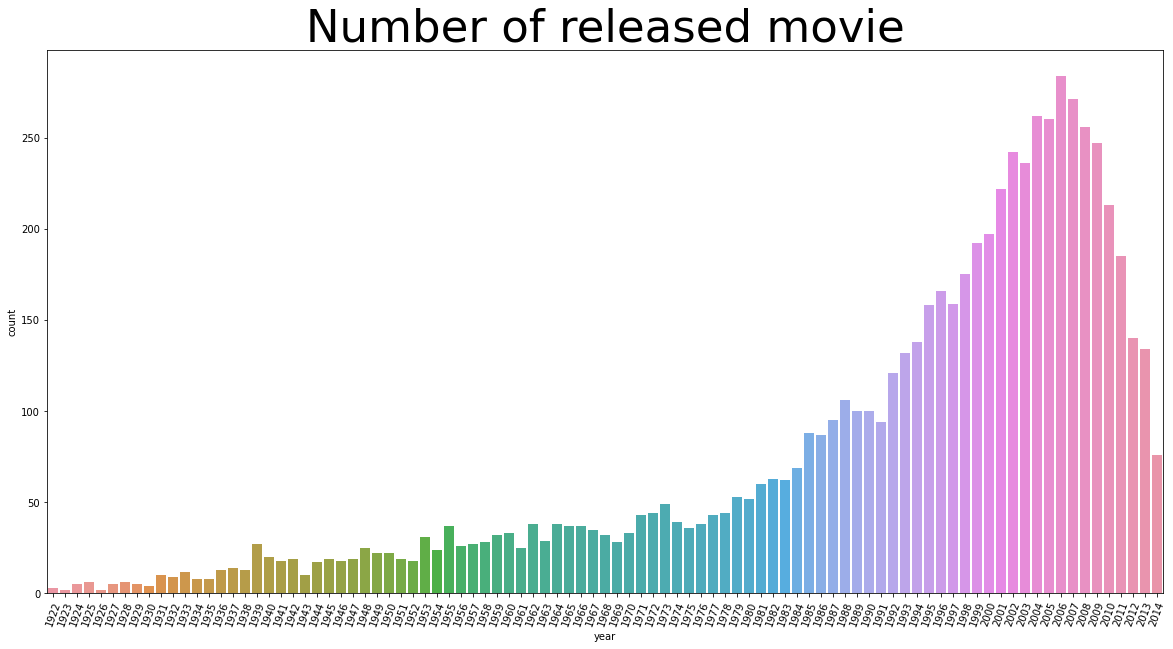

In [18]:
top_n = 5
most_release_year = years_df.value_counts(subset='year', sort=True)[:top_n]
print("영화를 가장 많이 개봉한 년도 (내림차순): \n", most_release_year)

fig, axes = plt.subplots(1, 1, figsize=(20, 10))

sns.countplot(
    x='year', data=years_df,
    order=np.sort(years_df['year'].unique()),
    ax=axes
)

axes.set_title(
    label="Number of released movie", 
    fontdict={
        'fontsize': 45,
        }
    )
axes.set_xticklabels(labels=axes.get_xticklabels(), rotation=70)

print()

## 3.2  Dorectprs

- \# of unique directors: 1340
- \# of item have years: 5503
    - 1277개의 item이 director에 대한 정보를 가지고 있지 않다.
- 결측값(null)은 없다.

In [20]:
directors_df = pd.read_csv(os.path.join(train_data_dir, 'directors.tsv'), sep='\t')

basic_df_info(directors_df, 'director')

top_n = 5
most_create_directors = directors_df.value_counts(subset='director', sort=True)[:top_n]
print("영화를 가장 많이 제작한 감독 (내림차순): \n", most_create_directors)

Number of unique items in director:  5503
Number of unique director:  1340

Missing vluae: 
item        0
director    0
dtype: int64

Statistics of director data: 
count          5905
unique         1340
top       nm0000095
freq             44
Name: director, dtype: object

영화를 가장 많이 제작한 감독 (내림차순): 
 director
nm0000095    44
nm0000033    33
nm0000142    31
nm0000229    29
nm0000217    26
dtype: int64
